In this blog post we are going to talk about the main concepts behind the non-parametric Radial Basis Function (RBF), particularly the variant known as RBF interpolation. We will go through sampling some data from the Rosenbrock test function and attempting to recover the function by interpolating the data with an RBF. The post is structured as follows:

 **Table of contents**

1. [Introduction](#introduction)
2. [Dataset](#dataset)
3. [Sampling](#sampling)
4. [Formulation](#formulation)
5. [Model](#model)
6. [Cross Validation](#cross_validation)
6. [References](#references)

<a id="introduction"></a>

# Introduction 

RBF's are a non-paramteric technique, meaning that they do not suffer from any bias due to making any assumption about the relationshp of the data before hand. As such they can be used for regression and can be extended to classification much like artificial neural networks (ANN), in fact often being classified as a type of ANN. In this post however we talk about a variant of the RBF where the data is interpolated, meaning that the function passes through every observation in the dataset. By allowing the RBF to interpolate the data (and inherently introducing some bias) we gain the simplicty of only having to tune for a single hyperparameter to capture a potentially complex function.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from cycler import cycler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [24]:
def SetGlobalDefaults(font_size):
    plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = [30,16]
    plt.rcParams['font.family'] = 'times new roman'
    plt.rcParams['font.size'] = font_size
    plt.rcParams['xtick.labelsize']=font_size
    plt.rcParams['ytick.labelsize']= font_size
    plt.rcParams['legend.fontsize']= font_size
    plt.rcParams['axes.labelsize']= font_size
    plt.rcParams['axes.titlesize']= font_size
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.viridis(np.linspace(0,1,10)))
    plt.rcParams['image.cmap'] = 'viridis'
    
SetGlobalDefaults(18)

<a id="dataset"></a>

# Dataset

To illustrate the RBF we will be looking at the Rosenbrock function using a two dimensional input, where the function is defined as:

$$y=f(x)=\sum_{i=1}^{d-1}[100(x_{i+1}-x_i^2)^2+(x_i-1)^2]$$

where $x_i \in [-2.048,2.048]$ and is illustrated in Figure 1. A good summary of the function can be found at [^1]. 

In [33]:
def rosenbrock(X):
    if X.ndim==1:
        X=X.reshape(1,-1)
    return np.sum((100.0*(X[:,1:] - X[:,:-1]**2.0)**2.0 + (1 - X[:,:-1])**2.0),axis=1)

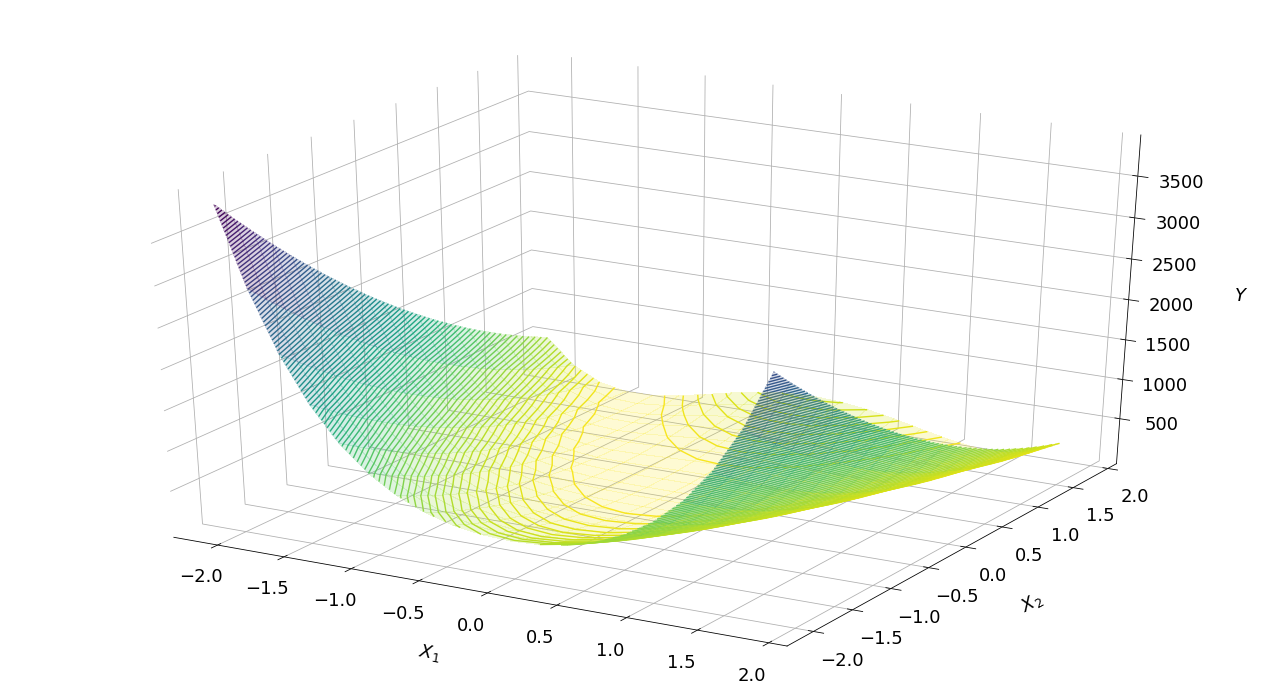

In [41]:
X1_sweep= np.arange(-2.048,2.048,(2*2.048)/20)
X2_sweep= np.arange(-2.048,2.048,(2*2.048)/20)
XX,YY=np.meshgrid(X1_sweep,X2_sweep)
zs=np.array([rosenbrock(np.array([x,y]).reshape(1,-1))for x,y in zip(np.ravel(XX), np.ravel(YY))])
Z = zs.reshape(XX.shape)

fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('$X_1$',labelpad=40)
ax.set_ylabel('$X_2$',labelpad=40)
ax.set_zlabel('$Y$',labelpad=40)
ax.tick_params(axis='both', which='major', pad=15)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
ax.contour(XX, YY, Z, 100, cmap='viridis_r')
plt.tight_layout()
#fig.savefig("2_rosenbrock.jpg",dpi=400,bbox_inches="tight")

<a id="sampling"></a>

# Sampling

To create some data to fit the function to, let us uniformly sample the input domain with 16 data points, illustrated in Figure 2. Using these as inputs to the Rosenbrock function we have the dataset $\mathcal{D}=(x_1,y_1),(x_2,y_2),...,(x_n,y_n)$, where $n$ =16. The case we are modelling here is often referred to as surrogate modelling, due to the fact that we will theoretically be representing 16 simulated data points with "unknown" relationship but use a regression function as its "surrogate". Remeber here that while we know that the data was smapled frm the Rosenbrock function, the RBF will never receive the Rosenbrock function as an input, we want to see if we can recover the Rosenbrock function using our RBF interpolant. 

In [51]:
def UniformSample(points_per_axis):
    xvalues = np.linspace(-2.048,2.048,points_per_axis)
    yvalues = np.linspace(-2.048,2.048,points_per_axis)
    xx, yy = np.meshgrid(xvalues, yvalues)
    return np.vstack((xx.flatten(),yy.flatten())).T,xx,yy

X,xx,yy=UniformSample(4)
y=rosenbrock(X)

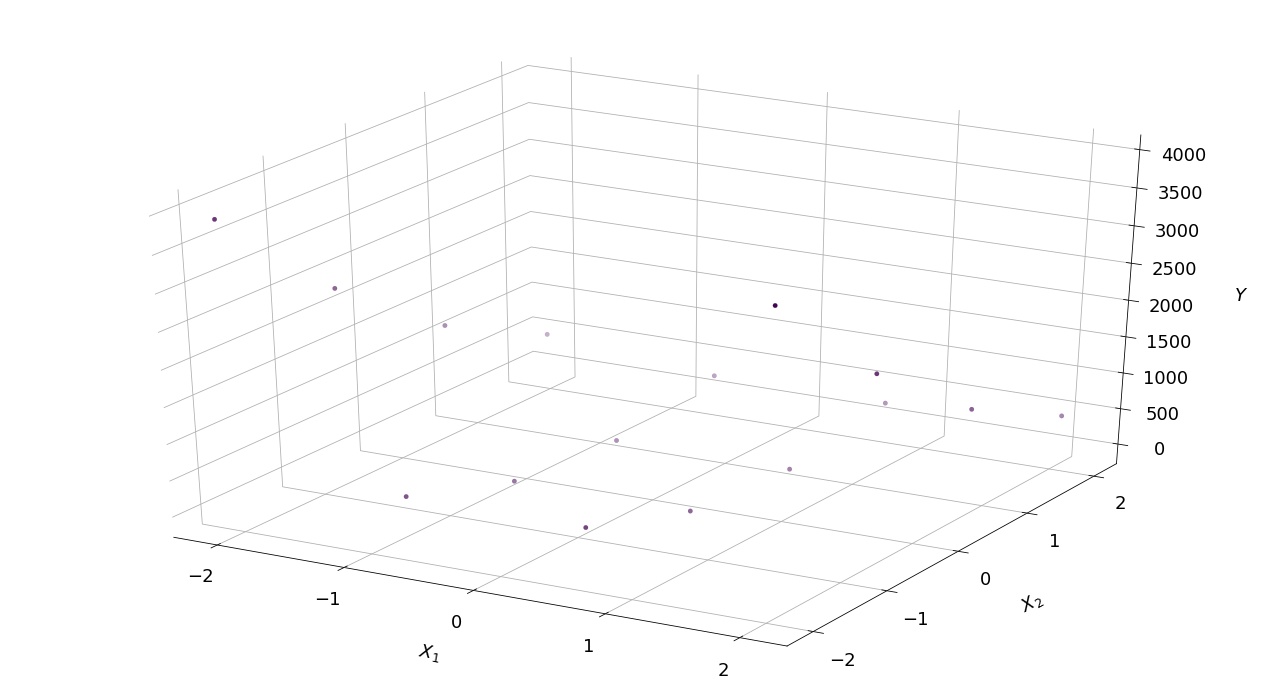

In [52]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('$X_1$',labelpad=40)
ax.set_ylabel('$X_2$',labelpad=40)
ax.set_zlabel('$Y$',labelpad=40)
ax.tick_params(axis='both', which='major', pad=15)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.scatter(X[:,0], X[:,1], y)
plt.tight_layout()

<a id="formulation"></a>

# Formulation

RBF's are a class of functions known as basis functions, however I find it easier to think of them as kernel functions where the input $x_i$ to a simple linear combination of inputs:

$$f(x)=\hat{y}=\sum_{i=1}^{n} w_i x_i$$

is replaced by a non-linear function (called a kernel) in a higher dimension so that we are taking a linear combination of non-linear functions (much like an ANN). In this case, the non linear function is the Gaussian function:

$$ k(x, x_c,\gamma) = exp(-\gamma ||x-x_c||^2) $$

so that: 
$$f(x)=\hat{y}=\sum_{i=1}^{n} w_i k_i(x,x_i,\gamma)$$

The RBF is given the name radial due to the fact that $k(x,x_c,\gamma)$ radially decreases in every direction about centre $x_c$ at a rate controlled by the decay parameter $\gamma$, illustrated in Figure 3.

$
K=
\begin{bmatrix}
k_1(x_1,x_1) & k_2(x_1,x_2) & \ldots &k_n(x_1,x_n)\\ 
k_1(x_2,x_1) & k_2(x_2,x_2) & \ldots &k_n(x_2,x_n)\\
\vdots & \vdots & \ddots
& \vdots \\
k_1(x_n,x_1) & k_2(x_n,x_2) & \ldots &k_n(x_n,x_n) 
\end{bmatrix}
$

$
\hat{w}=
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
w_n
\end{bmatrix}
$

$
\hat{y}
=\begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_n
\end{bmatrix}
$

$\hat{y}=\hat{w}K$

$
\hat{y}=
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
w_n
\end{bmatrix}
\begin{bmatrix}
k_1(x_1,x_1) & k_2(x_1,x_2) & \ldots &k_n(x_1,x_n)\\ 
k_1(x_2,x_1) & k_2(x_2,x_2) & \ldots &k_n(x_2,x_n)\\
\vdots & \vdots & \ddots
& \vdots \\
k_1(x_n,x_1) & k_2(x_n,x_2) & \ldots &k_n(x_n,x_n) 
\end{bmatrix}
$

Plot example of Gaussian Centres at Differing Shape parameters

In [6]:
def gaussian(gamma,x,c):
    return np.exp(-gamma*np.linalg.norm(x-c)**2)

def plot_gaussians(Xgrid,gamma,centre,num_pairs,figure_size,xlabel,ylabel,zlabel):
    '''Sweep Input1 and Input2 range in 100 steps'''
    X1_sweep= np.arange(min(Xgrid[:,0]),max(Xgrid[:,0]),(max(Xgrid[:,0])-min(Xgrid[:,0]))/num_pairs)
    X2_sweep= np.arange(min(Xgrid[:,1]),max(Xgrid[:,1]),(max(Xgrid[:,1])-min(Xgrid[:,1]))/num_pairs)

    '''Make square grid of sweep points'''
    XX,YY=np.meshgrid(X1_sweep,X2_sweep)

    '''Calculate estimator output of sweep point pairs'''
    zs1=np.array([gaussian(0.05,np.array([x,y]).reshape(-1,1),centre) for x,y in zip(np.ravel(XX), np.ravel(YY))])
    Z1 = zs1.reshape(XX.shape)
    
    zs2=np.array([gaussian(0.5,np.array([x,y]).reshape(-1,1),centre) for x,y in zip(np.ravel(XX), np.ravel(YY))])
    Z2 = zs2.reshape(XX.shape)
    
    zs3=np.array([gaussian(5,np.array([x,y]).reshape(-1,1),centre) for x,y in zip(np.ravel(XX), np.ravel(YY))])
    Z3 = zs3.reshape(XX.shape)

    '''Plot surface of RBF output based on sweep pairs'''
    fig = plt.figure(figsize=figure_size)
    
    labelpad=20
    ax1 = fig.add_subplot(1,3,1,projection='3d')
    ax1.set_xlabel(xlabel,labelpad=labelpad)
    ax1.set_ylabel(ylabel,labelpad=labelpad)
    ax1.set_zlabel(zlabel,labelpad=labelpad)
    ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.plot_surface(XX, YY, Z1, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
    ax1.contour(XX, YY, Z1, 100, cmap='viridis_r')

    
    ax2 = fig.add_subplot(1,3,2,projection='3d')
    ax2.set_xlabel(xlabel,labelpad=labelpad)
    ax2.set_ylabel(ylabel,labelpad=labelpad)
    ax2.set_zlabel(zlabel,labelpad=labelpad)
    ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax2.plot_surface(XX, YY, Z2, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
    ax2.contour(XX, YY, Z2, 100, cmap='viridis_r')

    
    ax3 = fig.add_subplot(1,3,3,projection='3d')
    ax3.set_xlabel(xlabel,labelpad=labelpad)
    ax3.set_ylabel(ylabel,labelpad=labelpad)
    ax3.set_zlabel(zlabel,labelpad=labelpad)
    ax3.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax3.plot_surface(XX, YY, Z3, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
    ax3.contour(XX, YY, Z3, 100, cmap='viridis_r')

    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    return fig,ax

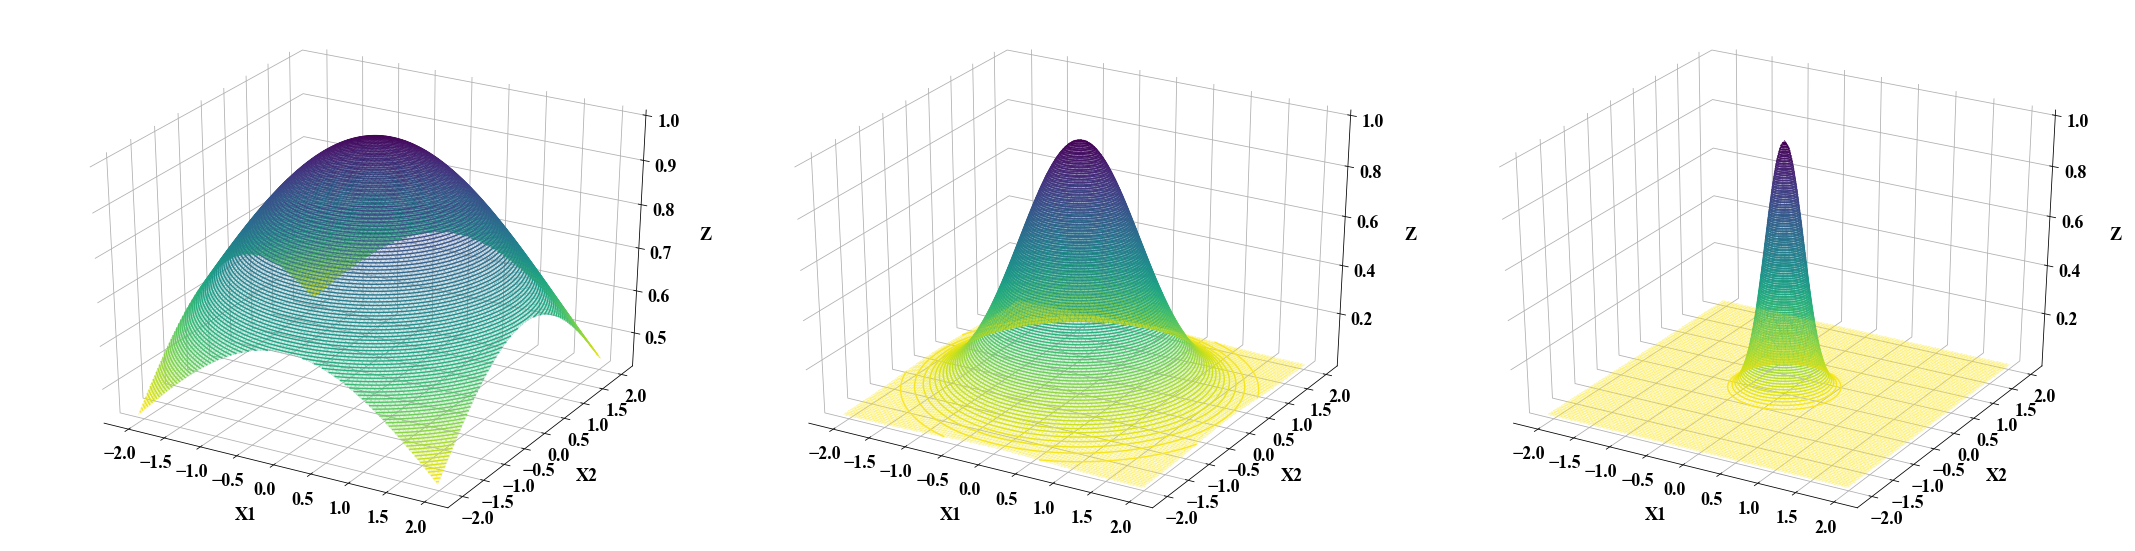

In [7]:
fig,ax=plot_gaussians(X,0.5,np.array([0,0]),100,(30,8),'X1','X2','Z')
fig.savefig("3_gaussian_centre.jpg",bbox_inches='tight',dpi=400)

Plot all 16 centres of sampled data for Rosenbrock function at a shape parameter of 0.5

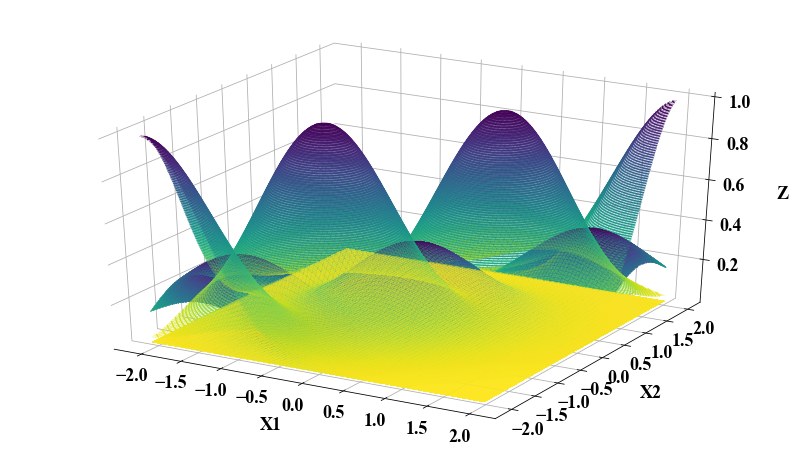

In [8]:
def plot_all_centres(Xgrid,gamma,centres,num_pairs,figure_size,xlabel,ylabel,zlabel):
    '''Sweep Input1 and Input2 range in 100 steps'''
    X1_sweep= np.arange(min(Xgrid[:,0]),max(Xgrid[:,0]),(max(Xgrid[:,0])-min(Xgrid[:,0]))/num_pairs)
    X2_sweep= np.arange(min(Xgrid[:,1]),max(Xgrid[:,1]),(max(Xgrid[:,1])-min(Xgrid[:,1]))/num_pairs)

    '''Make square grid of sweep points'''
    XX,YY=np.meshgrid(X1_sweep,X2_sweep)
    
    '''Plot surface of RBF output based on sweep pairs'''
    fig = plt.figure(figsize=figure_size)
    ax = fig.gca(projection='3d')
    
    labelpad=20
    ax.set_xlabel(xlabel,labelpad=labelpad)
    ax.set_ylabel(ylabel,labelpad=labelpad)
    ax.set_zlabel(zlabel,labelpad=labelpad)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    

    '''Calculate estimator output of sweep point pairs'''
    for i in centres:
        zs=np.array([gaussian(gamma,np.array([x,y]).reshape(-1,1),i) for x,y in zip(np.ravel(XX), np.ravel(YY))])
        Z = zs.reshape(XX.shape)
        ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
        ax.contour(XX, YY, Z, 100, cmap='viridis_r')
    return fig,ax

fig,ax=plot_all_centres(X,0.5,X,100,(14,8),'X1','X2','Z')
fig.savefig("4_all_centres.jpg",bbox_inches='tight',dpi=400)

<a id="model"></a>

# Model

Fit RBF to sampled data at a shape parameter of 0.5

In [9]:
class RBF(BaseEstimator):

    def __init__(self, gamma=0.1):
         self.gamma = gamma
            
    def fit(self, X, y):
        self.X_, self.y_ = check_X_y(X, y)
        self.Kernel_=rbf_kernel(self.X_,gamma=self.gamma)
        self.w_=np.linalg.pinv(self.Kernel_).dot(self.y_)
        return self

    def predict(self, X_pred):
        check_is_fitted(self, ['X_', 'y_'])
        if X_pred.ndim==1:
            X_pred=X_pred.reshape(1,-1)
        X_pred = check_array(X_pred)
        Kernel_pred=rbf_kernel(X_pred,self.X_,gamma=self.gamma)
        return Kernel_pred.dot(self.w_)
    
    def score(self, X, y=None):
        return np.mean((y-self.predict(X))**2,dpi=400)

In [10]:
clf=RBF(0.5)
clf.fit(X,y)

RBF(gamma=0.5)

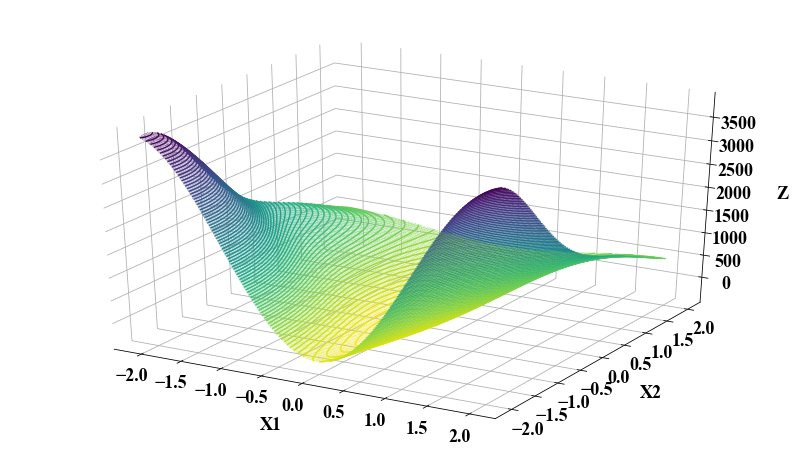

In [11]:
def plot_rbf(Xgrid,num_pairs,estimator,figure_size,xlabel,ylabel,zlabel):
    '''Sweep Input1 and Input2 range in 100 steps'''
    X1_sweep= np.arange(min(Xgrid[:,0]),max(Xgrid[:,0]),(max(Xgrid[:,0])-min(Xgrid[:,0]))/num_pairs)
    X2_sweep= np.arange(min(Xgrid[:,1]),max(Xgrid[:,1]),(max(Xgrid[:,1])-min(Xgrid[:,1]))/num_pairs)

    '''Make square grid of sweep points'''
    XX,YY=np.meshgrid(X1_sweep,X2_sweep)

    '''Calculate estimator output of sweep point pairs'''
    zs=np.array([estimator.predict(np.array([x,y])) for x,y in zip(np.ravel(XX), np.ravel(YY))])
    Z = zs.reshape(XX.shape)

    '''Plot surface of RBF output based on sweep pairs'''
    fig = plt.figure(figsize=figure_size)
    ax = fig.gca(projection='3d')
    ax.set_xlabel(xlabel,labelpad=20)
    ax.set_ylabel(ylabel,labelpad=20)
    ax.set_zlabel(zlabel,labelpad=20)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
    ax.contour(XX, YY, Z, 100, cmap='viridis_r')
    return fig,ax

fig,ax=plot_rbf(X,100,clf,(14,8),'X1','X2','Z')
fig.savefig("5_before_cv_surface.jpg",bbox_inches="tight",dpi=400)

Plot rbf at various shape paremeters over a large range:

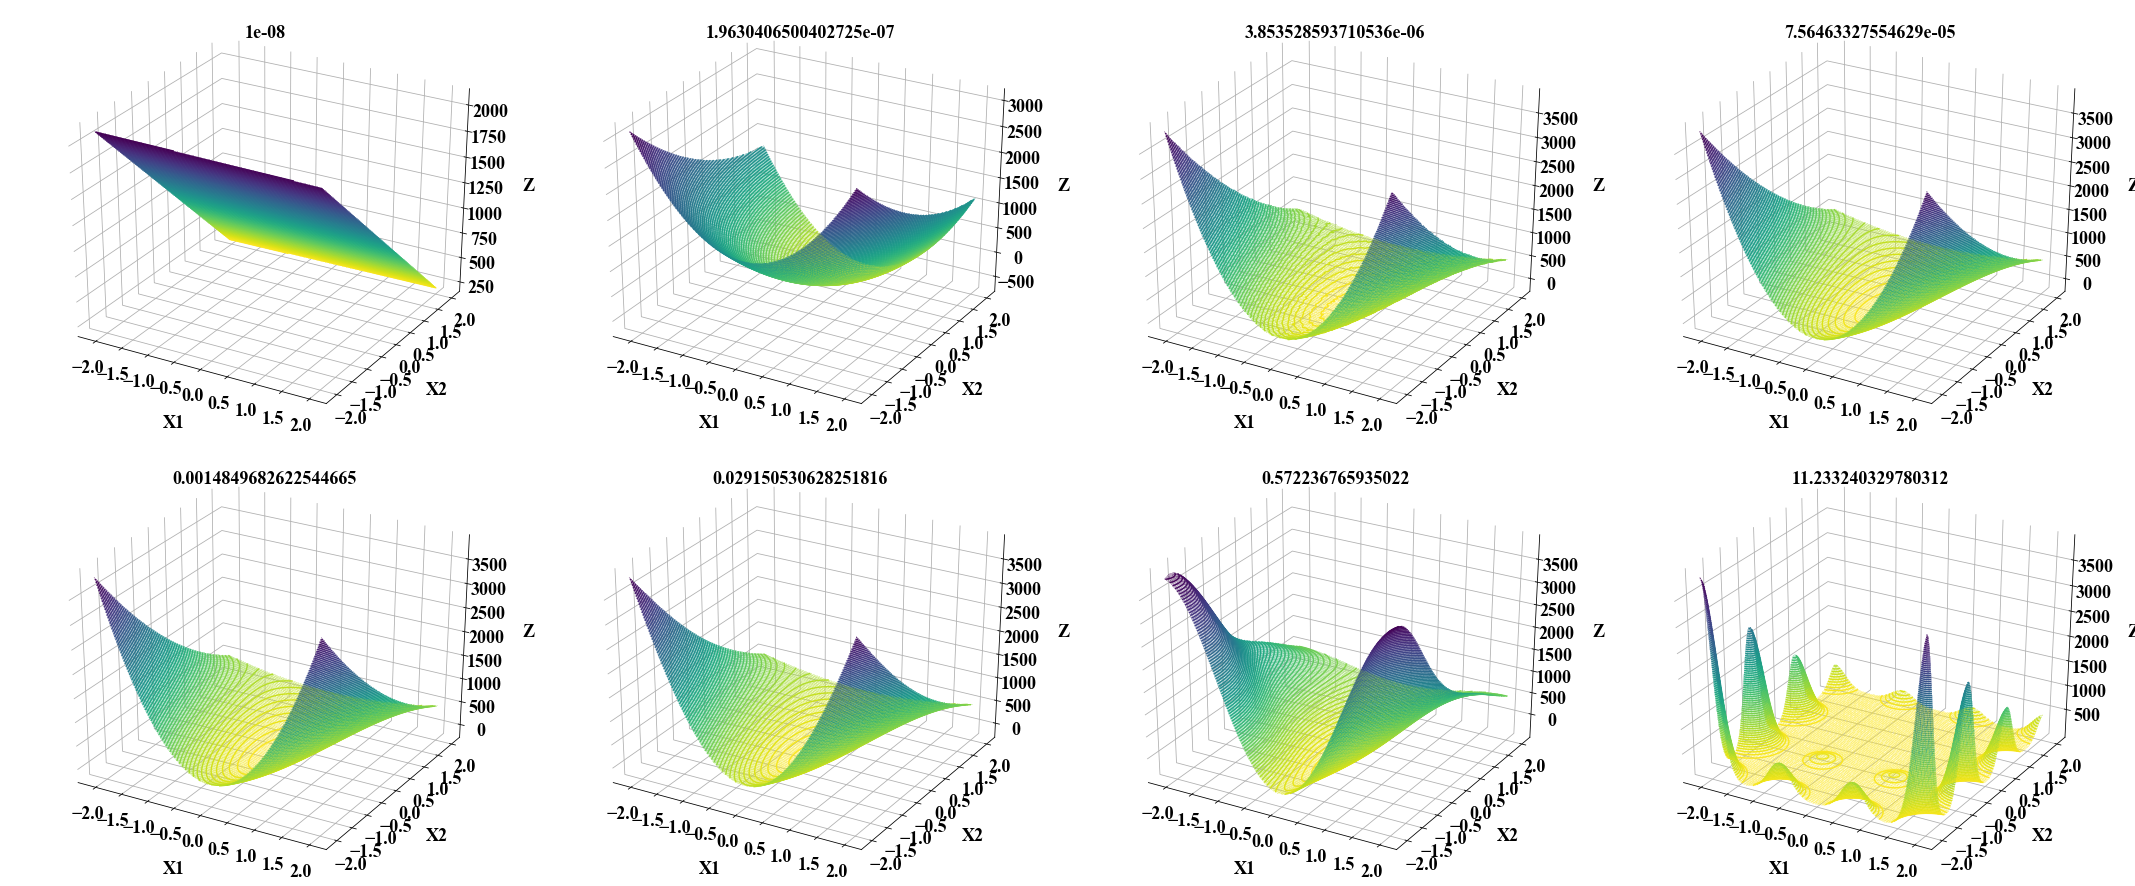

In [12]:
def grid_plot(Xgrid,ygrid,num_pairs,figure_size,xlabel,ylabel,zlabel):
    '''Sweep Input1 and Input2 range in 100 steps'''
    X1_sweep= np.arange(min(Xgrid[:,0]),max(Xgrid[:,0]),(max(Xgrid[:,0])-min(Xgrid[:,0]))/num_pairs)
    X2_sweep= np.arange(min(Xgrid[:,1]),max(Xgrid[:,1]),(max(Xgrid[:,1])-min(Xgrid[:,1]))/num_pairs)

    '''Make square grid of sweep points'''
    XX,YY=np.meshgrid(X1_sweep,X2_sweep)
    
    fig = plt.figure(figsize=figure_size)
    
    ax1 = fig.add_subplot(4,4,1,projection='3d')
    ax2 = fig.add_subplot(4,4,2,projection='3d')
    ax3 = fig.add_subplot(4,4,3,projection='3d')
    ax4 = fig.add_subplot(4,4,4,projection='3d')
    ax5 = fig.add_subplot(4,4,5,projection='3d')
    ax6 = fig.add_subplot(4,4,6,projection='3d')
    ax7 = fig.add_subplot(4,4,7,projection='3d')
    ax8 = fig.add_subplot(4,4,8,projection='3d')
    
    axes=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

        
    counter=0
    for count,i in enumerate(np.logspace(-8,8,100)):
        if count%8==0:
            if counter<len(axes):
                clf_plot=RBF(i)
                clf_plot.fit(Xgrid,ygrid)
                zs=np.array([clf_plot.predict(np.array([x,y])) for x,y in zip(np.ravel(XX), np.ravel(YY))])
                Z = zs.reshape(XX.shape)
                axes[counter].plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2,label="{}".format(i))
                axes[counter].set_xlabel(xlabel,labelpad=20)
                axes[counter].set_ylabel(ylabel,labelpad=20)
                axes[counter].set_zlabel(zlabel,labelpad=20)
                axes[counter].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                axes[counter].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                axes[counter].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                axes[counter].set_title("{}".format(i))
                axes[counter].contour(XX, YY, Z, 100, cmap='viridis_r')

                counter+=1
            else:
                break
    fig.tight_layout()
    return fig,ax
fig,ax=grid_plot(X,y,100,(30,25),'X1','X2','Z')
fig.savefig("6_gammas.jpg",box_inches="tight",pad_inches=0,dpi=400)

<a id="cross_validation"></a>

# Cross Validation

Perform Cross Validation and fit radial basis function using optimum shape parameter

In [13]:
def Cross_Validate(X_cv,y_cv):

    loo = LeaveOneOut()
    gamma_space=np.logspace(-8,8,100)
    gamma_tested=[]
    MSE=[]

    for count,i in enumerate(gamma_space):
        RSS=[]
        for train_index, test_index in loo.split(X):
            X_train, X_test = X_cv[train_index], X_cv[test_index]
            y_train, y_test = y_cv[train_index], y_cv[test_index]

            clf_cv=RBF(i)
            clf_cv.fit(X_train,y_train)

            y_pred=clf_cv.predict(X_test)
            RSS.append((y_pred-y_test)**2)

        MSE.append(np.mean(RSS))
        gamma_tested.append(i)
    best_gamma=gamma_space[np.argmin(MSE)] 
    return best_gamma,pd.DataFrame({'Gamma':gamma_tested,'MSE':MSE})
    
best_gamma,df=Cross_Validate(X,y)

Plot mean squared error

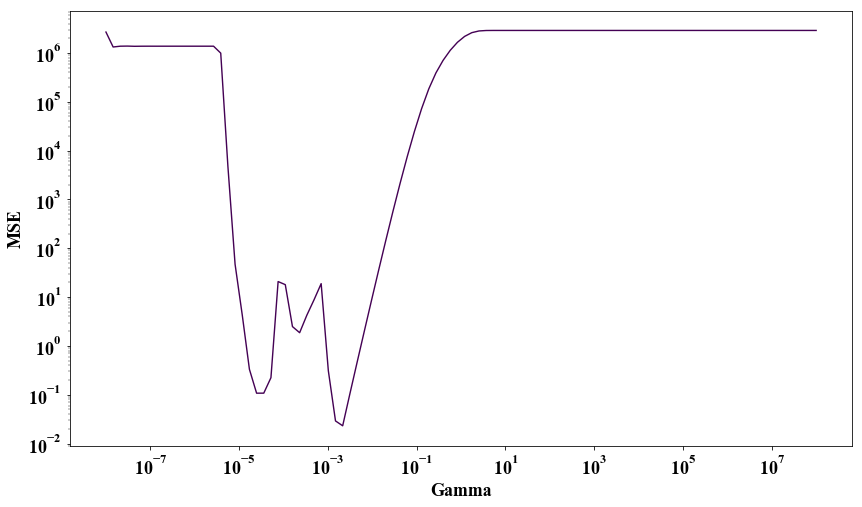

In [14]:
fig,ax=plt.subplots(figsize=(14,8))
ax.loglog(df.Gamma,df.MSE)
ax.set_xlabel("Gamma")
ax.set_ylabel("MSE")
fig.savefig("7_cross_validation.jpg",box_inches="tight",dpi=400)

In [15]:
clf=RBF(best_gamma)
clf.fit(X,y)

RBF(gamma=0.0021544346900318869)

Plot best rbf surface

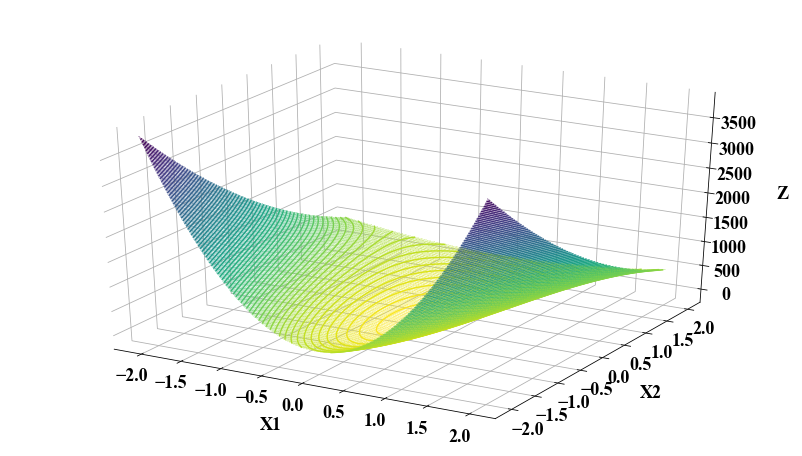

In [16]:
def grid_plot(Xgrid,num_pairs,estimator,figure_size,xlabel,ylabel,zlabel):
    '''Sweep Input1 and Input2 range in 100 steps'''
    X1_sweep= np.arange(min(Xgrid[:,0]),max(Xgrid[:,0]),(max(Xgrid[:,0])-min(Xgrid[:,0]))/num_pairs)
    X2_sweep= np.arange(min(Xgrid[:,1]),max(Xgrid[:,1]),(max(Xgrid[:,1])-min(Xgrid[:,1]))/num_pairs)

    '''Make square grid of sweep points'''
    XX,YY=np.meshgrid(X1_sweep,X2_sweep)

    '''Calculate estimator output of sweep point pairs'''
    zs=np.array([estimator.predict(np.array([x,y])) for x,y in zip(np.ravel(XX), np.ravel(YY))])
    Z = zs.reshape(XX.shape)

    '''Plot surface of RBF output based on sweep pairs'''
    fig = plt.figure(figsize=figure_size)
    ax = fig.gca(projection='3d')
    labelpad=20
    ax.set_xlabel(xlabel,labelpad=labelpad)
    ax.set_ylabel(ylabel,labelpad=labelpad)
    ax.set_zlabel(zlabel,labelpad=labelpad)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap='viridis_r',linewidth=0, antialiased=False,alpha=0.2)
    ax.contour(XX, YY, Z, 100, cmap='viridis_r')
    return fig,ax

fig,ax=grid_plot(X,100,clf,(14,8),'X1','X2','Z')
fig.savefig("8_best_gamma_surface.jpg",bbox_inches="tight",dpi=400)

Example using more sampled data

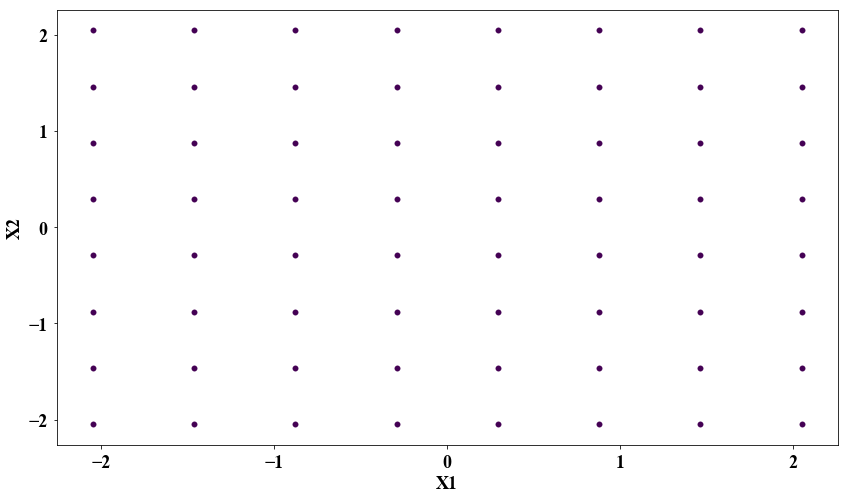

In [17]:
X,xx,yy=UniformSample(8)
fig,ax=plt.subplots(figsize=(14,8))
ax.scatter(xx,yy)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
fig.savefig("9_data_grid_64.jpg",bbox_inches="tight",dpi=400)

In [18]:
y=rosenbrock(X)
best_gamma,df=Cross_Validate(X,y)

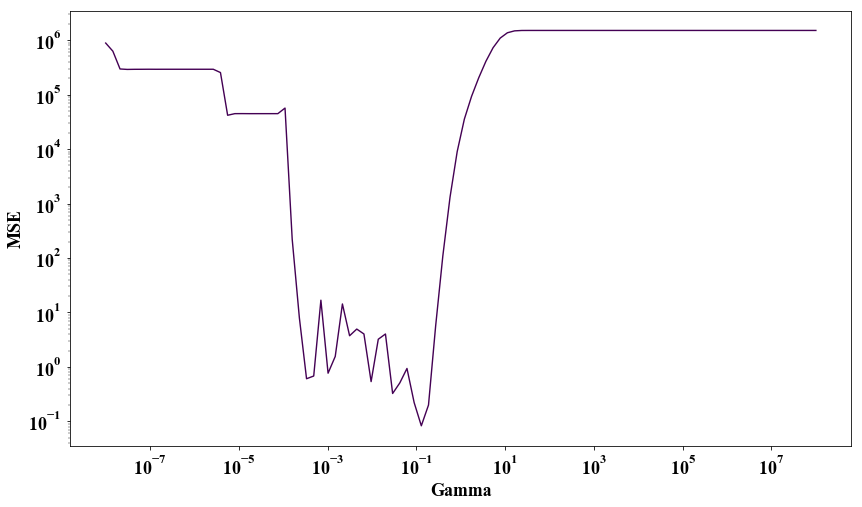

In [19]:
fig,ax=plt.subplots(figsize=(14,8))
ax.loglog(df.Gamma,df.MSE)
ax.set_xlabel("Gamma")
ax.set_ylabel("MSE")
fig.savefig("10_cross_validation_64.jpg",box_inches="tight",dpi=400)

In [20]:
clf=RBF(best_gamma)
clf.fit(X,y)

RBF(gamma=0.12915496650148853)

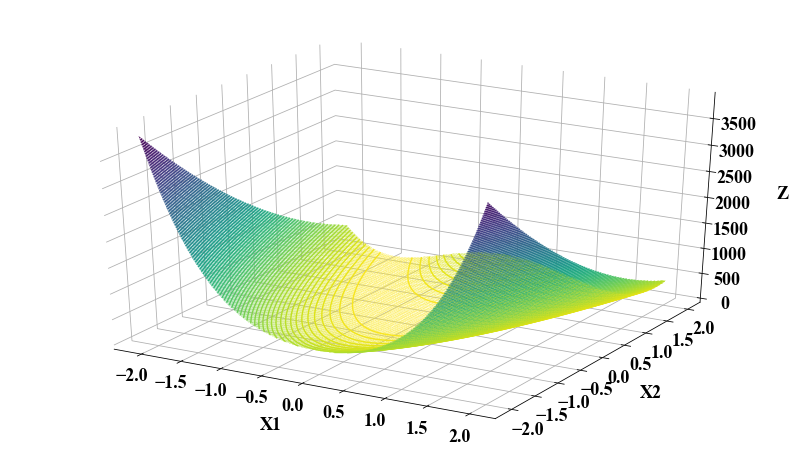

In [21]:
fig,ax=grid_plot(X,100,clf,(14,8),'X1','X2','Z')
fig.savefig("11_best_gamma_surface_64.jpg",bbox_inches="tight",dpi=400)

<a id="references"></a>

# References

* [^1]: https://www.sfu.ca/~ssurjano/rosen.html